# Covid-19 Transit Analysis -  Austin, TX
Mapping Ridership Per Stop

CapMetro Automatic Passenger Count (APC) Data - January 2020 to May 2020

## Setup

In [5]:
import pandas as pd, geopandas as gpd, numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import datetime

In [6]:
## Read in all our files- We will end up combining analysis of the APC data with the Geometries of the stops
apc = pd.read_csv(r'C:\Users\benca\Documents\new_jupyter\CapMetro_APC__RAW__-_January_2020.csv')
service_area = gpd.read_file(r'C:\Users\benca\Documents\new_jupyter\Capital_Metro_Shapefiles_-_JANUARY_2020 (1)\Service_Area.shp')
stops = gpd.read_file(r'C:\Users\benca\Documents\new_jupyter\Capital_Metro_Shapefiles_-_JANUARY_2020 (1)\stops.shp')

## Create a list of unique stop IDs from our geometries - stops we know we can map
## the shapefiles happen to already be unique
stop_ids = stops['STOP_ID'].unique()

## Creates a list of Bus stops logged in the APC data that aren't found in our stops geometries
## These are likely discontinued bus stops
a = apc[np.logical_not(apc['bs_id'].isin(stop_ids))]
discontinued_stops = a[a['bs_id']>0]['bs_id'].unique()


In [7]:
## Our source APC data has coordinates, but right now they are stored as decimal numbers
## Convert decimals into Shapely Point Objects and let geopandas convert into a geodataframe
apc1 = apc
apc1['coordinates'] = list(zip(apc1.veh_long, apc1.veh_lat))
apc1.coordinates = apc1.coordinates.apply(Point)
apc_geo = gpd.GeoDataFrame(apc1, geometry = 'coordinates')

## Filtered is all APC data where the Stop Number is included in the stops geometries, 
## plus removing partial transit days at beginning and end of dataset
## Stopless data is the roughly 1 million data points without a bus stop (10-15% of all data)
stopless_data = apc_geo[apc_geo['bs_id'] == 0]
filtered = apc_geo[(apc['bs_id'].isin(stop_ids)) & (apc_geo['current_route_id'] > 0) & (apc_geo['transit_date_time'] > 20200105000000) & (apc_geo['transit_date_time'] < 20200530000000)]

Fortunately, all the data with stop numbers- seem to have a high degree of accuracy with the geographic tracking

<AxesSubplot:>

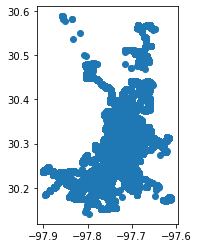

In [9]:
filtered.plot()

<AxesSubplot:>

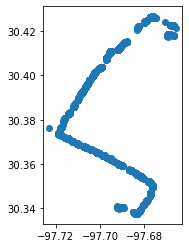

In [153]:
filtered[filtered['current_route_id'] == 325].plot()

The stopless data varies somewhat

<AxesSubplot:>

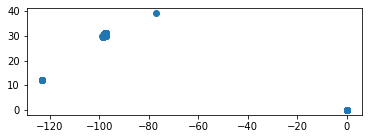

In [145]:
stopless_data.plot()

DISCLAIMER: CapMetro claims that this data won't line up with reported ridership- but when spot checked, all examples fell w/in +/- 5% MOE

Ridership on the 315 - Ben White is reported as 13.9K in April 2020, and below is the same information calculated from our filtered APC data

In [12]:
sum(filtered[(filtered['current_route_id'] == 315) & (filtered['transit_date_time'] > 20200331000000) & (filtered['transit_date_time'] < 20200501000000)]['ons'])

13840

7 - Duval / Dove Springs in the month of February is reported at 188.1K Riders

In [13]:
sum(filtered[(filtered['current_route_id'] == 7)&(filtered['transit_date_time']>=20200201000000)&(filtered['transit_date_time']<20200301000000)]['ons'])

185199

Our numbers are under by 1.5%

## Having found no glaring inaccuracies- I moved a subset of the filtered data into MySQL

In [18]:
to_mysql = filtered[['vehicle_id','operator_id','bs_id','current_route_id','direction_code_id','ons','offs','max_load','transit_date_time','open_date_time','close_date_time']].reset_index(drop=True)
to_mysql.to_csv('filtered_apc.csv')

,vehicle_id,operator_id,bs_id,current_route_id,direction_code_id,ons,offs,max_load,transit_date_time,open_date_time,close_date_time
0,2608,28520,1253,10,4,2,0,13,20200106000000,20200106150827,20200106150843
1,2366,24750,6334,318,8,4,0,7,20200106000000,20200106175058,20200106175202
2,2252,37080,5949,4,7,1,1,3,20200106000000,20200106071323,20200106071337
3,2721,600822,1143,325,4,2,2,7,20200106000000,20200106174122,20200106174140
4,2619,35560,5554,20,6,2,2,15,20200106000000,20200106193259,20200106193315
...,...,...,...,...,...,...,...,...,...,...,...
6647594,5002,600758,5873,801,4,2,0,2,20200405000000,20200405100645,20200405102138
6647595,2056,33030,1366,300,4,1,1,10,20200405000000,20200405105901,20200405105916
6647596,2853,25560,599,1,4,4,0,13,20200405000000,20200405212329,20200405212427
6647597,2710,27180,5226,350,6,1,0,1,20200405000000,20200405183937,20200405190326


In [10]:
%%sql

CREATE TABLE apc_2020(
    unique_id BIGINT,
    vehicle_id INT,
    operator_id INT,
    bs_id INT,
    current_route_id INT,
    direction_code_id INT,
    ons INT,
    offs INT,
    max_load INT,
    transit_date_time BIGINT,
    open_date_time BIGINT,
    close_date_time BIGINT,
    PRIMARY KEY (unique_id)
)

LOAD DATA INFILE 'filtered_apc.csv'
INTO TABLE apc_2020
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\r\n'
IGNORE 1 ROWS
;

## This creates a table where instances of boardings have been combined by stop, day, and bus route
## IE a row now tells you how many people got on what bus, at what stop, and on what day-
## Where the old dataset told you every single time the bus doors opened

SELECT transit_date_time, bs_id, current_route_id, sum(ons) as ons, sum(offs) as offs
FROM apc_2020
GROUP BY bs_id, current_route_id, transit_date_time
LIMIT 0,1000000;

## I wrote the results of the prior query into Notebook++ and saved as a .csv
## And I took that CSV into Tableau
## Where I linked the stop shapes with the APC analysis

UsageError: Cell magic `%%sql` not found.


In [3]:
%%html
<div class='tableauPlaceholder' id='viz1611937386032' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ri&#47;ridershipperstop&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ridershipperstop&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ri&#47;ridershipperstop&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1611937386032');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='1020px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>